In [1]:
!pip install torch # framework
!pip install --upgrade reedsolo
!pip install --upgrade librosa
!pip install torchvision
!pip install torchaudio 
!pip install tensorboard
!pip install soundfile
!pip install librosa==0.7.1
!pip install scikit-image==0.17.2

     |████████████████████████████████| 276kB 4.7MB/s 
  Created wheel for reedsolo: filename=reedsolo-1.5.4-cp36-cp36m-linux_x86_64.whl size=710786 sha256=63d3a7829344e74e30710cc7a7bcf4729e21acd0e3b17ca21663db9273306327
  Stored in directory: /root/.cache/pip/wheels/46/89/1a/0a99096e7310f4c2c150e02708622606f6094702e29cf6daeb
Successfully built reedsolo
     |████████████████████████████████| 184kB 4.5MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
  Created wheel for librosa: filename=librosa-0.8.0-cp36-none-any.whl size=201377 sha256=84e7d1342b45961880074cfdddd93a1d5d83f5c58d1cc589ad5f7811dffa8129
  Stored in directory: /root/.cache/pip/wheels/ee/10/1e/382bb4369e189938d5c02e06d10c651817da8d485bfd1647c9
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3
     |████████████████████████████████| 6.7MB 4.6MB/s 
     |████████████████████████████████| 748.8MB 17kB/s 
ERROR: torchvi

In [2]:
import numpy as np
import librosa
import librosa.display 
import datetime
import matplotlib.pyplot as plt
from torch.nn.functional import binary_cross_entropy_with_logits, mse_loss
from torchvision import datasets, transforms
from IPython.display import clear_output
import torchvision
#from torchvision.datasets.vision import VisionDataset
from torch.optim import Adam
from tqdm import notebook
import torch
import os.path
import os
import gc
import sys
from PIL import ImageFile, Image
from torchaudio import transforms as audiotransforms
import torchaudio
import soundfile 
from IPython.display import Audio
import random
import skimage
from skimage import transform

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [4]:
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard 

# to watch previous logs please change the path to the folder logs are stored into

current_time = datetime.datetime.now().strftime('%b%d_%H-%M-%S')
log_dir = os.path.join('results/runs', current_time )
os.makedirs(log_dir, exist_ok=True)
%tensorboard --logdir {log_dir}

<IPython.core.display.Javascript object>

In [5]:
epochs = 32
data_depth = 4
hidden_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LOAD_MODEL = True
PATH='results/model/DenseEncoder_DenseDecoder_+0.774_2020-07-28_15:51:10.dat'#'results/model/DenseEncoder_DenseDecoder_0.042_2020-07-23_02_08_27.dat'
audio = True

In [6]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

# -*- coding: utf-8 -*-

import zlib
from math import exp

import torch
from reedsolo import RSCodec
from torch.nn.functional import conv2d

rs = RSCodec(250)


def text_to_bits(text):
    """Convert text to a list of ints in {0, 1}"""
    return bytearray_to_bits(text_to_bytearray(text))


def bits_to_text(bits):
    """Convert a list of ints in {0, 1} to text"""
    return bytearray_to_text(bits_to_bytearray(bits))


def bytearray_to_bits(x):
    """Convert bytearray to a list of bits"""
    result = []
    for i in x:
        bits = bin(i)[2:]
        bits = '00000000'[len(bits):] + bits
        result.extend([int(b) for b in bits])

    return result


def bits_to_bytearray(bits):
    """Convert a list of bits to a bytearray"""
    ints = []
    for b in range(len(bits) // 8):
        byte = bits[b * 8:(b + 1) * 8]
        ints.append(int(''.join([str(bit) for bit in byte]), 2))

    return bytearray(ints)


def text_to_bytearray(text):
    """Compress and add error correction"""
    assert isinstance(text, str), "expected a string"
    x = zlib.compress(text.encode("utf-8"))
    x = rs.encode(bytearray(x))
    return x

def bytearray_to_text(x):
    """Apply error correction and decompress"""
    try:
      #print('1: ',x)
      text = rs.decode(x)[0]
      #print('2: ',x)
      text = zlib.decompress(text)
      #print('3: ',x)
      return text.decode("utf-8")
    except BaseException as e: 
      #print(e)
      return False

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)


In [7]:
import torch
from torch import nn
import numpy

# TRY REMOVE BATCH NORMALIZATION FROM ENCODER
class BasicEncoder(nn.Module):
    """
    The BasicEncoder module takes an cover image and a data tensor and combines
    them into a steganographic image.

    """
    def _name(self):
      return "BasicEncoder"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(self.channels_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size + self.data_depth, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size, self.channels_size),
        )
        return self.conv1, self.conv2, self.conv3, self.conv4

    def __init__(self, data_depth, hidden_size, channels_size):
        super().__init__()
        self.data_depth = data_depth
        self.hidden_size = hidden_size
        self.channels_size= channels_size
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image, data):
        x = self._models[0](image)
        x_1 = self._models[1](torch.cat([x] + [data], dim=1))
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3


class ResidualEncoder(BasicEncoder):
    def _name(self):
      return "ResidualEncoder"

    def forward(self, image, data):
        return image + super().forward(self, image, data)


class DenseEncoder(BasicEncoder):
    def _name(self):
      return "DenseEncoder"

    def _build_models(self):
        self.conv1 = super()._build_models()[0]
        self.conv2 = super()._build_models()[1]
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size * 2 +
                         self.data_depth, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size * 3 + self.data_depth, self.channels_size)
        )

        return self.conv1, self.conv2, self.conv3, self.conv4

    def forward(self, image, data):
        x = self._models[0](image)
        x_list = [x]
        x_1 = self._models[1](torch.cat(x_list+[data], dim=1))
        x_list.append(x_1)
        x_2 = self._models[2](torch.cat(x_list+[data], dim=1))
        x_list.append(x_2)
        x_3 = self._models[3](torch.cat(x_list+[data], dim=1))
        x_list.append(x_3)
        return image + x_3


In [8]:
import torch
from torch import nn
#from torch.nn import Sigmoid
#from torch.distributions import Bernoulli


class BasicDecoder(nn.Module):
    """
    The BasicDecoder module takes an steganographic image and attempts to decode
    the embedded data tensor.

    Input: (N, 3, H, W)
    Output: (N, D, H, W)
    """
    def _name(self):
      return "BasicDecoder"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(self.channels_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size, self.data_depth),
            #nn.Sigmoid(),
        )

        return self.conv1, self.conv2, self.conv3, self.conv4

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        #x_4 = Bernoulli(x_3).sample()
        return x_3

    def __init__(self, data_depth, hidden_size, channels_size):
        super().__init__()
        self.data_depth = data_depth
        self.hidden_size = hidden_size
        self.channels_size= channels_size
        self._models = self._build_models()
        self.name = self._name()


class DenseDecoder(BasicDecoder):
    def _name(self):
      return "DenseDecoder"

    def _build_models(self):
        self.conv1 = super()._build_models()[0]
        self.conv2 = super()._build_models()[1]
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size * 2, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size)
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size * 3, self.data_depth),
            #nn.Sigmoid(),
        )

        return self.conv1, self.conv2, self.conv3, self.conv4

    def forward(self, image):
        x = self._models[0](image)
        x_list = [x]
        x_1 = self._models[1](torch.cat(x_list, dim=1))
        x_list.append(x_1)
        x_2 = self._models[2](torch.cat(x_list, dim=1))
        x_list.append(x_2)
        x_3 = self._models[3](torch.cat(x_list, dim=1))
        x_list.append(x_3)
        return x_3


In [9]:
import torch
from torch import nn


class BasicCritic(nn.Module):
    """
    The BasicCritic module takes an image and predicts whether it is a cover
    image or a steganographic image (N, 1).

    Input: (N, 3, H, W)
    Output: (N, 1)
    """
    def _name(self):
      return "BasicCritic"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3
        )

    def _build_models(self):

        self.conv1 = nn.Sequential(
            self._conv2d( self.channels_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )  
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size, 1)
        )         

        return self.conv1,self.conv2,self.conv3,self.conv4

    def __init__(self, hidden_size, channels_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.channels_size= channels_size
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return torch.mean(x_3.view(x_3.size(0), -1), dim=1)
        

In [10]:
def plot(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('validation_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
#     if save:
#         now = datetime.datetime.now()
#         get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
#                         (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [11]:
def test(encoder,decoder,data_depth,train_epoch,cover,payload):
  %matplotlib inline
  generated = encoder.forward(cover, payload)
  decoded = decoder.forward(generated)
  decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
  decoder_acc = (decoded >= 0.0).eq(
    payload >= 0.5).sum().float() / payload.numel() # .numel() calculate the number of element in a tensor
  print("Decoder loss: %.3f"% decoder_loss.item())
  print("Decoder acc: %.3f"% decoder_acc.item())
  f, ax = plt.subplots(1, 3)
  f.suptitle("%s_%s"%(encoder.name,decoder.name), fontsize=16)
  cover_=np.transpose(np.squeeze(cover.cpu()), (1, 2, 0))
  ax[0].imshow(cover_)
  ax[0].invert_yaxis()
  ax[0].axis('off')
  ax[0].set_title('Cover image')
  generated_=np.transpose(np.squeeze((generated.cpu()).detach().numpy()), (1, 2, 0))
  ax[1].imshow(generated_)
  ax[1].invert_yaxis()
  ax[1].axis('off')
  ax[1].set_title('Generated image')
  payload=cover_-generated_
  ax[2].imshow(payload)
  ax[2].invert_yaxis()
  ax[2].axis('off')
  ax[2].set_title('Generated payload')
  return generated

In [12]:
def save_model(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,ep):
    now = datetime.datetime.now()
    cover_score = metrics['val.decoder_acc'][-1]
    name = "%s_%s_%+.3f_%s.dat" % (encoder.name,decoder.name,cover_score,
                                   now.strftime("%Y-%m-%d_%H:%M:%S"))
    fname = os.path.join('.', 'results/model', name)
    states = {
            'state_dict_critic': critic.state_dict(),
            'state_dict_encoder': encoder.state_dict(),
            'state_dict_decoder': decoder.state_dict(),
            'en_de_optimizer': en_de_optimizer.state_dict(),
            'cr_optimizer': cr_optimizer.state_dict(),
            'metrics': metrics,
            'train_epoch': ep,
            'date': now.strftime("%Y-%m-%d_%H:%M:%S"),
    }
    torch.save(states, fname)

In [13]:
def fit_gan(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,train_loader,valid_loader):
      iter_train_critic=0
      iter_train_enc_dec=0
      iter_valid=0
      for ep in range(epochs):
        print("Epoch %d" %(ep+1))
        for cover, *rest in notebook.tqdm(train_loader):
            if torch.cuda.is_available():
              cover = cover.cuda()
            iter_train_critic+=1
            gc.collect()
            cover = cover.to(device)
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)
            cover_score = torch.mean(critic.forward(cover))
            generated_score = torch.mean(critic.forward(generated))

            cr_optimizer.zero_grad()
            (cover_score - generated_score).backward(retain_graph=False)
            cr_optimizer.step()
            
            for p in critic.parameters():
                p.data.clamp_(-0.1, 0.1)
            writer.add_scalar('cover_score/train', cover_score.item(), iter_train_critic)
            writer.add_scalar('generated_score/train', generated_score.item(), iter_train_critic)

            metrics['train.cover_score'].append(cover_score.item())
            metrics['train.generated_score'].append(generated_score.item())
              
            for tag, value in critic.named_parameters():
              tag = tag.replace('.', '/')
              writer.add_histogram('critic/'+tag, value.data.cpu().numpy(), iter_train_critic)
              writer.add_histogram('critic/'+tag+'/grad', value.grad.data.cpu().numpy(), iter_train_critic)

        for cover, *rest in notebook.tqdm(train_loader):
            if torch.cuda.is_available():
              cover = cover.cuda()
            iter_train_enc_dec+=1
            gc.collect()
            cover = cover.to(device)
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)
            decoded = decoder.forward(generated)
            encoder_mse = mse_loss(generated, cover)
            decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
            decoder_acc = (decoded >= 0.0).eq(
                payload >= 0.5).sum().float() / payload.numel()
            generated_score = torch.mean(critic.forward(generated))

            en_de_optimizer.zero_grad()
            (100 * encoder_mse + decoder_loss +
             generated_score).backward()  # Why 100?
            en_de_optimizer.step()

            writer.add_scalar('encoder_mse/train', encoder_mse.item(), iter_train_enc_dec)
            writer.add_scalar('decoder_loss/train', decoder_loss.item(), iter_train_enc_dec)
            writer.add_scalar('decoder_acc/train', decoder_acc.item(), iter_train_enc_dec)

            metrics['train.encoder_mse'].append(encoder_mse.item())
            metrics['train.decoder_loss'].append(decoder_loss.item())
            metrics['train.decoder_acc'].append(decoder_acc.item())

            for tag, value in encoder.named_parameters():
              tag = tag.replace('.', '/')
              writer.add_histogram('encoder/'+tag, value.data.cpu().numpy(), iter_train_enc_dec)
              writer.add_histogram('encoder/'+tag+'/grad', value.grad.data.cpu().numpy(), iter_train_enc_dec)

            for tag, value in decoder.named_parameters():
              tag = tag.replace('.', '/')
              writer.add_histogram('decoder/'+tag, value.data.cpu().numpy(), iter_train_enc_dec)
              writer.add_histogram('decoder/'+tag+'/grad', value.grad.data.cpu().numpy(), iter_train_enc_dec)
            
        for cover, *rest in notebook.tqdm(valid_loader):
            if torch.cuda.is_available():
              cover = cover.cuda()
            iter_valid+=1
            gc.collect()
            cover = cover.to(device)
            
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)

            decoded = decoder.forward(generated)

            encoder_mse = mse_loss(generated, cover)
            decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
            decoder_acc = (decoded >= 0.0).eq(
                payload >= 0.5).sum().float() / payload.numel()
            generated_score = torch.mean(critic.forward(generated))
            cover_score = torch.mean(critic.forward(cover))

            ssim_=ssim(cover, generated)
            psnr_=10 * torch.log10(4 / encoder_mse)
            bbp_=data_depth * (2 * decoder_acc.item() - 1)

            writer.add_scalar('encoder_mse/test', encoder_mse.item(), iter_valid)
            writer.add_scalar('decoder_loss/test', decoder_loss.item(), iter_valid)
            writer.add_scalar('decoder_acc/test', decoder_acc.item(), iter_valid)
            writer.add_scalar('cover_score/test', cover_score.item(), iter_valid)
            writer.add_scalar('generated_score/test', generated_score.item(), iter_valid)
            writer.add_scalar('ssim/test', ssim_.item(), iter_valid)
            writer.add_scalar('psnr/test', psnr_.item(), iter_valid)
            writer.add_scalar('bbp/test',bbp_, iter_valid)

            metrics['val.encoder_mse'].append(encoder_mse.item())
            metrics['val.decoder_loss'].append(decoder_loss.item())
            metrics['val.decoder_acc'].append(decoder_acc.item())
            metrics['val.cover_score'].append(cover_score.item())
            metrics['val.generated_score'].append(generated_score.item())
            metrics['val.ssim'].append(ssim_.item())
            metrics['val.psnr'].append(psnr_.item())
            metrics['val.bpp'].append(bbp_)

        if audio:
          writer.add_image('cover/test', torch.tensor(np.abs(cover[:,0,:,:].cpu().detach().numpy()+1j*cover[:,1,:,:].cpu().detach().numpy())).unsqueeze(0), ep, dataformats='CNHW')
          writer.add_image('generated/test', torch.tensor(np.abs(generated[:,0,:,:].cpu().detach().numpy()+1j*generated[:,1,:,:].cpu().detach().numpy())).unsqueeze(0), ep, dataformats='CNHW')
          writer.add_image('payload/test', torch.tensor(np.abs((cover[:,0,:,:].cpu().detach().numpy()+1j*cover[:,1,:,:].cpu().detach().numpy())-(generated[:,0,:,:].cpu().detach().numpy()+1j*generated[:,1,:,:].cpu().detach().numpy()))).unsqueeze(0), ep, dataformats='CNHW')
        else:
          writer.add_image('cover/test', cover, ep, dataformats='NCHW')
          writer.add_image('generated/test', generated, ep, dataformats='NCHW')
          writer.add_image('payload/test', cover-generated, ep, dataformats='NCHW')

        print('encoder_mse: %.3f - decoder_loss: %.3f - decoder_acc: %.3f - cover_score: %.3f - generated_score: %.3f - ssim: %.3f - psnr: %.3f - bpp: %.3f'
          %(encoder_mse.item(),decoder_loss.item(),decoder_acc.item(),cover_score.item(),generated_score.item(), ssim_.item(),psnr_.item(),bbp_))
      
        save_model(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,ep)
        
      writer.add_graph(encoder,(cover, payload))
      writer.add_graph(decoder,generated)
      writer.add_graph(critic,generated)
      writer.close()

In [24]:
AUD_EXTENSIONS = ('.flac', '.wav', '.mp3', '.mp4')

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.

    Args:
        filename (string): path to a file
        extensions (tuple of strings): extensions to consider (lowercase)

    Returns:
        bool: True if the filename ends with one of given extensions
    """
    return filename.lower().endswith(extensions)


def is_image_file(filename):
    """Checks if a file is an allowed image extension.

    Args:
        filename (string): path to a file

    Returns:
        bool: True if the filename ends with a known image extension
    """
    return has_file_allowed_extension(filename, IMG_EXTENSIONS)


def make_dataset(directory, class_to_idx, extensions=None, is_valid_file=None):
    instances = []
    directory = os.path.expanduser(directory)
    both_none = extensions is None and is_valid_file is None
    both_something = extensions is not None and is_valid_file is not None
    if both_none or both_something:
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
    if extensions is not None:
        def is_valid_file(x):
            return has_file_allowed_extension(x, extensions)
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(directory, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path):
                    item = path, class_index
                    instances.append(item)
    return instances

def wav_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        sig, sr = torchaudio.load(f.name)
        #sig = torchaudio.transforms.Resample(sr, 5000)(sig[0,:].view(1,-1))
        #sig, sr = librosa.load(f.name,sr=22050)
        return sig


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return wav_loader(path)

class AudioToImageFolder(datasets.DatasetFolder):
    """A generic audio data loader where the images are arranged in this way: """

    def __init__(self, root, transform=None, target_transform=None,
                 loader=default_loader, is_valid_file=None):
        super(AudioToImageFolder, self).__init__(root, loader, AUD_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
        self.imgs = self.samples

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = wav_loader(path) #custom
        if self.transform is not None:
            sample = self.transform(sample)
            hop_length=sample[1]
            sample=sample[0]
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, path, hop_length


In [25]:
  from collections import Counter
def make_payload(width, height, depth, text):
    """
    This takes a piece of text and encodes it into a bit vector. It then
    fills a matrix of size (width, height) with copies of the bit vector.
    """
    message = text_to_bits(text) + [0] * 32

    payload = message
    while len(payload) < width * height * depth:
        payload += message

    payload = payload[:width * height * depth]

    return torch.FloatTensor(payload).view(1, depth, height, width)

def make_message(image):
    image = image.to(device)

    image = decoder(image).view(-1) > 0
    image=torch.tensor(image, dtype=torch.uint8)

    # split and decode messages
    candidates = Counter()
    bits = image.data.cpu().numpy().tolist()
    for candidate in bits_to_bytearray(bits).split(b'\x00\x00\x00\x00'):
      #print(candidate)
      candidate = bytearray_to_text(bytearray(candidate))
      if candidate:
          candidates[candidate] += 1

    # choose most common message
    if len(candidates) == 0:
      raise ValueError('Failed to find message.')

    candidate, count = candidates.most_common(1)[0]
    return candidate


In [26]:
def plot_audio(mel):
  fig, ax = plt.subplots()
  img = librosa.display.specshow(mel, x_axis='time', fmin=0,fmax=6000,
                          y_axis='mel', sr=6000, ax=ax)
  fig.colorbar(img, ax=ax,format='%+2.0f dB')


In [27]:
def test_audio(encoder,decoder,data_depth,train_epoch,cover,payload):
  %matplotlib inline
  generated = encoder.forward(cover, payload)
  decoded = decoder.forward(generated)
  decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
  decoder_acc = (decoded >= 0.0).eq(
    payload >= 0.5).sum().float() / payload.numel() # .numel() calculate the number of element in a tensor
  print("Decoder loss: %.3f"% decoder_loss.item())
  print("Decoder acc: %.3f"% decoder_acc.item())
  f, ax = plt.subplots(1, 3,figsize=(16,5))
  f.suptitle("%s_%s"%(encoder.name,decoder.name), fontsize=16)
  f.tight_layout(pad=4.0)
  if len(cover.shape)==4:
    cover_=cover.squeeze(0).cpu().detach().numpy()
  else:
    cover_=cover.cpu().detach().numpy()
  cover_spec=cover_[0]+1j*cover_[1]
  librosa.display.specshow(cover_spec, x_axis='time', fmin=0,fmax=22050,
                          y_axis='mel', sr=22050, ax=ax[0])
  ax[0].set_title('Cover image')
  if len(generated.shape)==4:
    generated_=generated.squeeze(0).cpu().detach().numpy()
  else:
    generated_=generated.cpu().detach().numpy()
  generated_spec=generated_[0]+1j*generated_[1]
  librosa.display.specshow(generated_spec, x_axis='time', fmin=0,fmax=22050,
                          y_axis='mel', sr=22050, ax=ax[1])
  ax[1].set_title('Generated image')
  payload_=cover_spec-generated_spec
  img=librosa.display.specshow(payload_, x_axis='time', y_axis='mel', fmin=0,fmax=22050,
                           sr=22050, ax=ax[2])
  ax[2].set_title('Generated payload')

  return generated

In [33]:
def aud_to_melspectro(wav):
   wav=wav[0]
   len_=wav.shape[0]
   hop_length_=int(len_/(360-1))
   n_fft_=int((360-1)*2)
   mel=librosa.stft(np.asarray(wav),n_fft=n_fft_, hop_length=hop_length_)
   H_,W_=mel.shape
   mel_real=np.real(mel)
   mel_imag=np.imag(mel)
   if not mel_real.shape == (360,360):
      mel_real=skimage.transform.resize(image=mel_real,output_shape=(360,360),order=1)
   if not mel_imag.shape == (360,360):
      mel_imag=skimage.transform.resize(image=mel_imag,output_shape=(360,360),order=1)
   return torch.tensor([mel_real,mel_imag]).float(), hop_length_



In [34]:
if __name__ == '__main__':
  for func in [
            lambda: os.mkdir(os.path.join('.', 'results')),
            lambda: os.mkdir(os.path.join('.', 'results/model')),
            lambda: os.mkdir(os.path.join('.', 'results/plots'))]:  # create directories
    try:
      func()
    except Exception as error:
      print(error)
      continue

  METRIC_FIELDS = [
        'val.encoder_mse',
        'val.decoder_loss',
        'val.decoder_acc',
        'val.cover_score',
        'val.generated_score',
        'val.ssim',
        'val.psnr',
        'val.bpp',
        'train.encoder_mse',
        'train.decoder_loss',
        'train.decoder_acc',
        'train.cover_score',
        'train.generated_score',
  ]

  writer = SummaryWriter(log_dir)
  print('Tensorboard logs stored in: ',writer.get_logdir())

  if audio:
    print('audio')
    data_dir="FSDKaggle2018"#"genres"#"music_speech" # directory to audio
    channels_size=2
    transform = transforms.Compose([transforms.Lambda(lambda wav: aud_to_melspectro(wav))])
    train_set = AudioToImageFolder(os.path.join(
          data_dir, "train/"), transform=transform)
    part_train_set = torch.utils.data.random_split(train_set, [800, len(train_set)-800])[0]
    train_loader = torch.utils.data.DataLoader(
          part_train_set, batch_size=4, shuffle=True,)
    valid_set = AudioToImageFolder(os.path.join( 
          data_dir, "val/"), transform=transform)
    part_valid_set = torch.utils.data.random_split(valid_set, [100, len(valid_set)-100])[0]
    valid_loader = torch.utils.data.DataLoader(
          part_valid_set, batch_size=4, shuffle=True)
  else:
    print('image')
    data_dir = 'div2k'
    mu = [.5, .5, .5]
    sigma = [.5, .5, .5]
    channels_size=3
    transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(
                                          360, pad_if_needed=True),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mu, sigma)])
    train_set = datasets.ImageFolder(os.path.join(
          data_dir, "train/"), transform=transform)
    train_loader = torch.utils.data.DataLoader(
          train_set, batch_size=4, shuffle=True)
    valid_set = datasets.ImageFolder(os.path.join( 
          data_dir, "val/"), transform=transform)
    valid_loader = torch.utils.data.DataLoader(
          valid_set, batch_size=4, shuffle=False)

  encoder = DenseEncoder(data_depth, hidden_size,channels_size).to(device)
  decoder = DenseDecoder(data_depth, hidden_size,channels_size).to(device)
  critic = BasicCritic(hidden_size,channels_size).to(device)
  cr_optimizer = Adam(critic.parameters(), lr=1e-4)
  en_de_optimizer = Adam(list(decoder.parameters()) + list(encoder.parameters()), lr=1e-4)
  metrics = {field: list() for field in METRIC_FIELDS}

  if LOAD_MODEL: 
    if torch.cuda.is_available():
      checkpoint = torch.load(PATH)
    else:
      checkpoint = torch.load(PATH, map_location=lambda storage, loc: storage)
              
    critic.load_state_dict(checkpoint['state_dict_critic'])
    encoder.load_state_dict(checkpoint['state_dict_encoder'])
    decoder.load_state_dict(checkpoint['state_dict_decoder'])
    en_de_optimizer.load_state_dict(checkpoint['en_de_optimizer'])
    cr_optimizer.load_state_dict(checkpoint['cr_optimizer'])
    metrics=checkpoint['metrics']
    ep=checkpoint['train_epoch']
    date=checkpoint['date']
    critic.train(mode=False)
    encoder.train(mode=False)
    decoder.train(mode=False)
    print('GAN loaded')
    print(critic)
    print(encoder)
    print(decoder)
    print(en_de_optimizer)
    print(cr_optimizer)
    print(date)
  else:
    fit_gan(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,train_loader,valid_loader)
                

[Errno 17] File exists: './results'
[Errno 17] File exists: './results/model'
[Errno 17] File exists: './results/plots'
Tensorboard logs stored in:  results/runs/Jul28_19-18-39
audio
GAN loaded
BasicCritic(
  (conv1): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)
DenseEncoder(
  (con

Decoder loss: 0.481
Decoder acc: 0.733


/usr/local/lib/python3.6/dist-packages/librosa/display.py:725: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Message found:  Lorem ipsum


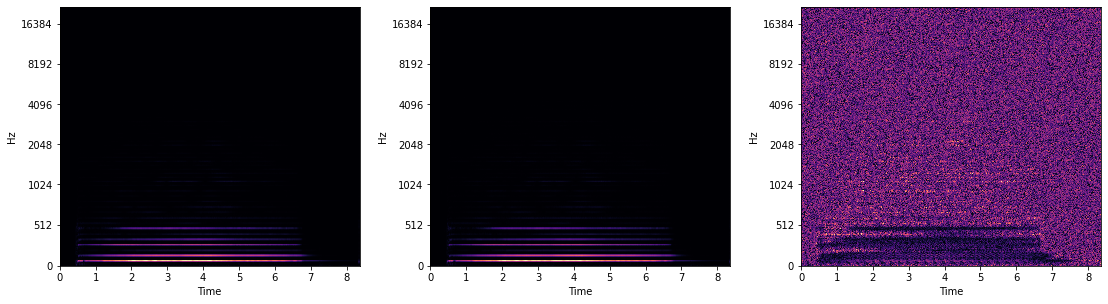

In [35]:
if audio:
  cover, path, hop_length = valid_set[101]
else:
  cover, *rest = next(iter(valid_set))

_, H, W = cover.size()
cover = cover[None].to(device)

text = "Lorem ipsum"
payload = make_payload(W, H, data_depth, text)
payload = payload.to(device)
if audio:
  generated = test_audio(encoder,decoder,data_depth,epochs,cover,payload)
else:
  generated = test(encoder,decoder,data_depth,epochs,cover,payload)

text_return_ = make_message(generated)

print('Message found: ',text_return_)

In [36]:
Audio(path, autoplay=True) # ORIGINAL AUDIO

In [37]:
   generated_=generated.squeeze(0).cpu().detach().numpy()
   mel_rec=generated_[0]+1j*generated_[1]
   print(mel_rec.shape)
   aud=librosa.istft(mel_rec, hop_length=hop_length_)
   print(aud.shape)
   librosa.output.write_wav('test.wav', aud, sr=22050*2)

   Audio('test.wav', autoplay=True) # GENERATED

(360, 360)
(166576,)


In [38]:
   wav, sr = librosa.load("test.wav",sr=22050)
   len_=wav.shape[0]
   hop_length_=int(len_/(360-1))
   n_fft_=int((360-1)*2)
   mel=librosa.stft(np.asarray(wav),n_fft=n_fft_, hop_length=hop_length_)
   H_,W_=mel.shape
   mel_real=np.real(mel)
   mel_imag=np.imag(mel)
   if not mel_real.shape == (360,360):
      mel_real=skimage.transform.resize(image=mel_real,output_shape=(360,360),order=1)
   if not mel_imag.shape == (360,360):
      mel_imag=skimage.transform.resize(image=mel_imag,output_shape=(360,360),order=1)
   cover=torch.tensor([mel_real,mel_imag])
   #print(cover.shape)
   text_return_ = make_message(cover[None])

   print('Message found: ',text_return_)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ValueError: ignored